# USPEX prism point-source reduction example

Last updated 13 March 2023

This notebook demonstrates the reduction of a USPEX prism point-source data using the test data provided with the code in test_data/uspex-prism


## Steps:
* setup instrument parameters (WORKING)
* reduce calibration data (WORKING)
* extract science point source (WORKING)
* extract telluric standard point source (WORKING)
* combine individual science spectra into one spectrum (TBD)
* combine individual telluric spectra into one spectrum (TBD)
* telluric calibration science spectrum (TBD)
* stitch orders for SXD data (TBD)


## Setup

In [1]:
# initial imports and setup
import pyspextool as ps
import os

# what instrument and mode we are using
instrument = 'uspex'
mode = 'prism'

# point to test data folder for USPEX prism data
# NOTE: this should be moved internally
pfolder = os.path.dirname(os.path.abspath(ps.__file__))+'/../../'
tdfolder = pfolder+'/test_data/{}-{}/'.format(instrument,mode)

# set output pathways
redux_folder = '/Users/adam/projects/spex_archive/test_uspex-prism/'
raw_path = tdfolder
cal_path = redux_folder+'/cals/'
proc_path = redux_folder+'/proc/'
qa_path = redux_folder+'/cals/'

# file prefixes
src_prefix = 'sbd.2022B046.221019.spc.'
flat_prefix = 'sbd.2022B046.221019.flat.'
arc_prefix = 'sbd.2022B046.221019.arc.'

# file numbers
flat_files = '15-19'
arc_files = '20'
src_files = '1-2'
tell_files = '7-8'

# extraction details
orders = '1' # orders to extract
source_type = 'ps' # source type: 'ps' (default) or 'xs'
reduction_mode = 'A-B' # reduction mode: 'A-B' (default), 'A', 'A-Sky/Dark'
npos = 2
aperture_positions = [3.7, 11.2] # preset aperture positions
aperture_method = 'auto' # method to identify aperture: 'fixed', 'guess', or 'auto' (default)
ps_aperture = 1.5 # preset aperture width for point source in multiples of PSF radius
psf_radius = 1.5 # point source PSF radius
ps_bg_parameters = [2.5,4] # point source background parameters; radius to start, then width

# set up instrument
ps.pyspextool_setup(instrument,raw_path=raw_path, cal_path=cal_path, proc_path=proc_path, qa_path=qa_path,verbose=True)



Pyspextool Setup
----------------
Instrument:  uspex

Rawpath:  /Users/adam/python_codes/pyspextool/test_data/uspex-prism
Calpath:  /Users/adam/projects/spex_archive/test_uspex-prism/cals
Procpath:  /Users/adam/projects/spex_archive/test_uspex-prism/proc
Qapath:  /Users/adam/projects/spex_archive/test_uspex-prism/cals

QA Extension: .pdf 



## Calibrations

 
Make Flat Field
---------------
Loading FITS images...
Scaling images...
Medianing the images...
Locating the orders...
Normalizing the median image...
Writing flat to disk...
Flat field flat15-19.fits written to disk.

Make Wavecal File
-----------------
Loading FITS images...
Extracting 1 apertures in 1 orders (without background subtraction)...
100% |**********************************************************************|
Using stored solution...
Writing wavecal to disk...
Wavecal wavecal20.fits written to disk.



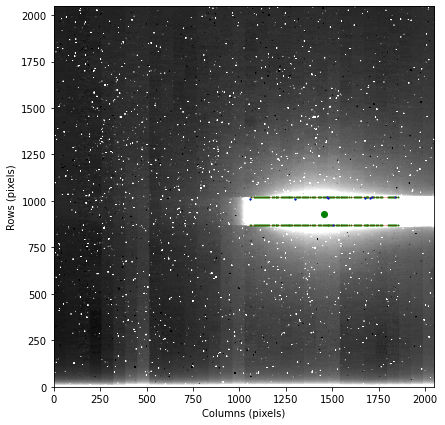

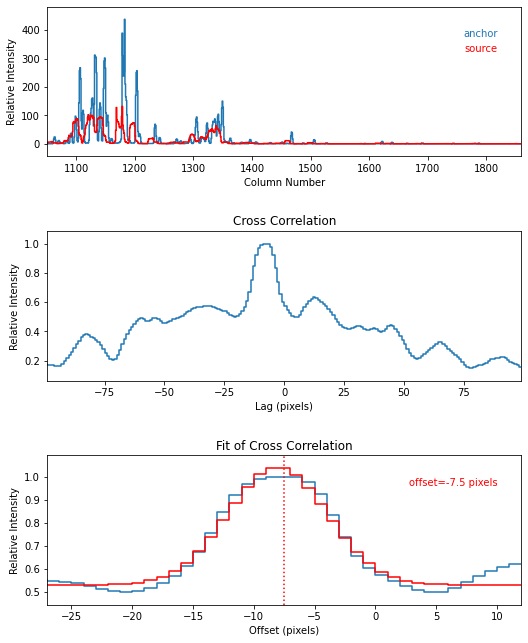

In [2]:
# conduct calibrations
ps.extract.make_flat(flat_files,'flat{}'.format(flat_files),prefix=flat_prefix,qafile=True,verbose=True)

# note: use stored solution unless slit width = 0.3
ps.extract.make_wavecal(arc_files,'flat{}.fits'.format(flat_files),'wavecal{}'.format(arc_files),\
    prefix=arc_prefix,qafile_findlines=True,use_stored_solution=True,verbose=True)


## Extract science files

In [3]:
# extract first two images of science target

# load in images and apply flat and wavecal calbrations
ps.extract.load_image([src_prefix,ps.io.files.extract_filestring(src_files,method='index')[:2]],\
                      'flat{}.fits'.format(flat_files), 'wavecal{}.fits'.format(arc_files),\
                      flat_field=True, linearity_correction=True,reduction_mode=reduction_mode, \
                      qaplot=False, qafile=True, verbose=True)

# set extraction method to point source
ps.extract.set_extraction_type(source_type)

# make spatial profiles
ps.extract.make_spatial_profiles(qaplot=False, qafile=False, verbose=True)

# identify aperture positions (set above)
if aperture_method=='auto': # this works for method = 'auto'
    ps.extract.locate_aperture_positions(2, method=aperture_method, qaplot=False, qafile=True, verbose=True)
else:
    ps.extract.locate_aperture_positions(aperture_positions, method=aperture_method, qaplot=False, qafile=True, verbose=True)

# select orders to extract (set above)
ps.extract.select_orders(include=orders, qaplot=False, qafile=False, verbose=True)

# trace apertures
ps.extract.trace_apertures(qaplot=False, qafile=True, verbose=True)

# define the aperture - psf, width, background
ps.extract.define_aperture_parameters(ps_aperture, psf_radius=psf_radius,bg_radius=ps_bg_parameters[0],\
                        bg_width=ps_bg_parameters[1], qaplot=False, qafile=True) #, verbose=True

# extract away
ps.extract.extract_apertures(verbose=True)


Loading the flat...
Loading the wavecal...
Loading sbd.2022B046.221019.spc.00001.a.fits, sbd.2022B046.221019.spc.00002.b.fits and correcting for non-linearity...
Flat fielding the image...
Setting extraction type to point source...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 1 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00001.fits to disk.
Wrote spectra00002.fits to disk.
 


In [4]:
# conduct extraction of all remaining files
# NOTE: this is redundant for the first two files,
# and also unnecessary here because we only have 2 files!

ps.extract.do_all_steps([src_prefix,src_files])


Loading sbd.2022B046.221019.spc.00001.a.fits, sbd.2022B046.221019.spc.00002.b.fits and correcting for non-linearity...
Flat fielding the image...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 1 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00001.fits to disk.
Wrote spectra00002.fits to disk.
 


## Extract telluric/flux cal spectrum

In [5]:
# now do telluric source

# load in images and apply flat and wavecal calbrations
ps.extract.load_image([src_prefix,ps.io.files.extract_filestring(tell_files,method='index')[:2]],\
                      'flat{}.fits'.format(flat_files), 'wavecal{}.fits'.format(arc_files),\
                      flat_field=True, linearity_correction=True,reduction_mode=reduction_mode, \
                      qaplot=False, qafile=True, verbose=True)

# set extraction method to point source
ps.extract.set_extraction_type(source_type)

# make spatial profiles
ps.extract.make_spatial_profiles(qaplot=False, qafile=True, verbose=True)

# identify aperture positions (set above)
if aperture_method=='auto': # this works for method = 'auto'
    ps.extract.locate_aperture_positions(2, method=aperture_method, qaplot=False, qafile=True, verbose=True)
else:
    ps.extract.locate_aperture_positions(aperture_positions, method=aperture_method, qaplot=False, qafile=True, verbose=True)

# select orders to extract (set above)
ps.extract.select_orders(include=orders, qaplot=False, qafile=True, verbose=True)

# trace apertures
ps.extract.trace_apertures(qaplot=False, qafile=True, verbose=True)

# define the aperture - psf, width, background
ps.extract.define_aperture_parameters(ps_aperture, psf_radius=psf_radius,bg_radius=ps_bg_parameters[0],\
                        bg_width=ps_bg_parameters[1], qaplot=False, qafile=True) #, verbose=True

# extract away
ps.extract.extract_apertures(verbose=True)

# now do all files
ps.extract.do_all_steps([src_prefix,tell_files])


Loading the flat...
Loading the wavecal...
Loading sbd.2022B046.221019.spc.00007.a.fits, sbd.2022B046.221019.spc.00008.b.fits and correcting for non-linearity...
Flat fielding the image...
Setting extraction type to point source...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 1 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00007.fits to disk.
Wrote spectra00008.fits to disk.
 
Loading sbd.2022B046.221019.spc.00007.a.fits, sbd.2022B046.221019.spc.00008.b.fits and correcting for non-linearity...
Flat fielding the image...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...

## Combine science and telluric spectra into a single spectrum each

[This has not been completed yet]

## Flux calibrate science spectrum with telluric spectrum

[This has not been completed yet]

# Checking your outputs

You should find several output files in your cals and proc folders that allow you to visualize the calibrations and extractions. In addition, you can read in the spectrum and visualize it with plot_spectra.py


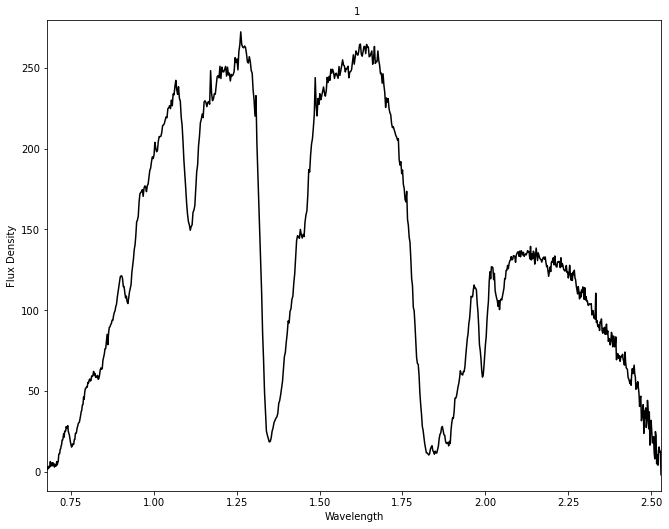

In [6]:
# plot with default parameters
from pyspextool.plot.plot_spectra import plot_spectra

file = 'spectra00001.fits'

ax = plot_spectra(proc_path+file,colors='k',y="flux")

Text(0.5, 1.0, 'spectra00001.fits')

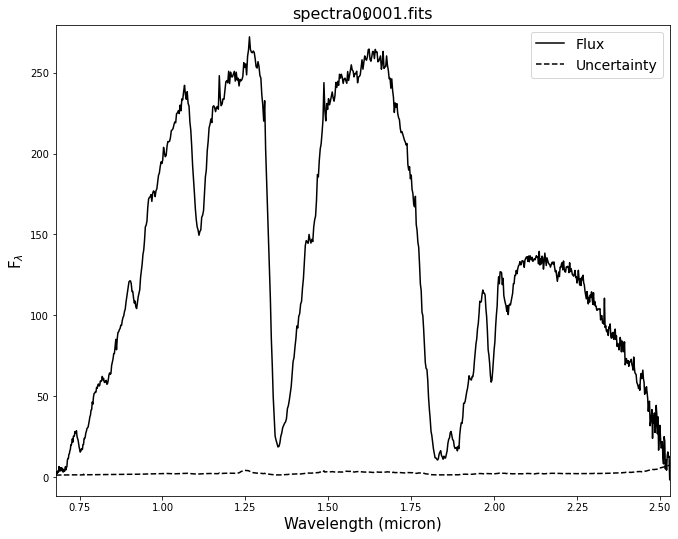

In [7]:
# plot with some modifications
file = 'spectra00001.fits'

ax = plot_spectra(proc_path+file,colors='k',y="flux and uncertainty",display=False)
ax.set_xlabel('Wavelength (micron)', fontsize=15)
ax.set_ylabel('F$_{\lambda}$', fontsize=15)
ax.legend(['Flux','Uncertainty'],fontsize=14)
ax.set_title(file,fontsize=16)
